**Грамматика**

```
<выражение> ->
    <арифметическое выражение> <знак операции отношения> <арифметическое выражение>

<арифметическое выражение> ->
    <терм> |
    <знак операции типа сложение> <терм> |
    <арифметическое выражение> <знак операции типа сложение> <терм>

<терм> ->
    <множитель> |
    <терм> <знак операции типа умножение> <множитель>

<множитель> ->
    <первичное выражение> |
    <множитель> ^ <первичное выражение>

<первичное выражение> ->
    <число> |
    <идентификатор> |
    ( <арифметическое выражение> )

<знак операции типа сложение> ->
    + | -

<знак операции типа умножение> ->
    * | / | %

<знак операции отношения> ->
    < | <= | = | >= | > | <>
```

Преобразованная грамматика


```
<выражение> ->
    <арифметическое выражение> <знак операции отношения> <арифметическое выражение>

<арифметическое выражение> ->
    [ <знак операции типа сложение> ] <терм> { <знак операции типа сложение> <терм> }

<терм> ->
    <множитель> [ <знак операции типа умножение> <терм> ]

<множитель> ->
    <первичное выражение> [ ^ <множитель> ]

<первичное выражение> ->
    <число> |
    <идентификатор> |
    ( <арифметическое выражение> )

<знак операции типа сложение> ->
    + | -

<знак операции типа умножение> ->
    * | / | %

<знак операции отношения> ->
    < | <= | = | >= | > | <>
```

Преобразованная грамматика 2


```
<выражение> ->
    <арифметическое выражение> <знак операции отношения> <арифметическое выражение>

<арифметическое выражение 2> ->
    <терм> <знак операции типа сложение> <арифметическое выражение 2> 
    <терм>

<арифметическое выражение> ->
    <знак операции типа сложение> <арифметическое выражение 2> |
    <арифметическое выражение 2>

<терм> ->
    <множитель> <знак операции типа умножение> <терм> |
    <множитель>

<множитель> ->
    <первичное выражение> [ ^ <множитель> ]

<первичное выражение> ->
    <число> |
    <идентификатор> |
    ( <арифметическое выражение> )

<знак операции типа сложение> ->
    + | -

<знак операции типа умножение> ->
    * | / | %

<знак операции отношения> ->
    < | <= | = | >= | > | <>
```

In [1]:
from __future__ import annotations


class ParseNode:
    data = ""
    children: list[ParseNode]
    from_ = -1
    to_ = -1

    attrs = None

    def __init__(self, data) -> None:
        self.data = data
        self.children = []
        self.attrs = []

    def add_child(self, node: ParseNode):
        if not len(self.children):
            self.from_ = node.from_
        self.to_ = node.to_

        if node.data in ["<proxy>"]:
            for ch in node.children:
                self.add_child(ch)
            return

        self.children.append(node)

    def print(self, tree=None, parent="", id="main"):
        from graphviz import Digraph

        if not tree:
            tree = Digraph()
            tree.node_attr["shape"] = "plain"
        tree.node(id, str(self.data) + "\n" + " ".join([str(x) for x in self.attrs]))
        if parent:
            tree.edge(parent, id)

        # print("IN:",  self.data, [ch.data for ch in self.children])
        for i, child in enumerate(self.children):
            child.print(tree, id, id + "." + str(i))
        # print("OUT:",  self.data, [ch.data for ch in self.children])

        return tree

In [2]:
import IPython


def test(func, tests: tuple[str, str], full, cmp=lambda a, b: repr(a) == repr(b)):
    output = "<table><thead><tr><td><div style='width:200px'>Вход</div></td><td><div style='width:200px'>Ожидаемый результат</div></td><td><div style='width:200px'>Действительный результат</div></td><td>Комментарий</td></tr></thead><tbody>"
    for test in tests:
        l = func(test[0])
        res = cmp(l, test[1])
        if not res or full:
            output += "<tr><td>\n\n{:}\n</td><td>\n\n{:}\n</td><td>\n\n{:}</td><td>\n\n{:}\n</td></tr>\n".format(
                repr(test[0]),
                repr(test[1]),
                repr(l),
                "OK" if res else "ERROR",
            )
    output += "</tbody></table>"
    return output


In [3]:
from __future__ import annotations

def make_parse_lexem(lexem: str):
    def parse_lexem(lexems: list[str], startPos: int):
        if startPos >= len(lexems):
            return None
        if lexems[startPos] == lexem:
            tree = ParseNode(lexem)
            tree.from_ = startPos
            tree.to_ = startPos + 1
            return tree
        return None

    return parse_lexem


def make_choice(rules):
    def combinator(lexems: typing.List[str], startPos: int):
        for rule in rules:
            node = rule(lexems, startPos)
            if not node:
                continue
            return node

        return None

    return combinator


def make_combine(rules, actions = None):
    def combinator(lexems: list[str], startPos: int):
        tree = ParseNode("<proxy>")
        curPos = startPos
        for rule in rules:
            node = rule(lexems, curPos)
            if not node:
                return None

            tree.add_child(node)
            curPos = node.to_
        return tree

    def action_wrapper(lexems: list[str], startPos: int):
        tree = combinator(lexems, startPos)
        if tree and actions:
            tree.attrs = actions(*tree.children)
        return tree

    return action_wrapper


def parse_rel_op(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_parse_lexem("<"),
            make_parse_lexem("<="),
            make_parse_lexem("="),
            make_parse_lexem(">="),
            make_parse_lexem(">"),
            make_parse_lexem("!="),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    # tree.data = "<операция отношения>"
    return tree


def parse_mult_op(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_parse_lexem("*"),
            make_parse_lexem("/"),
            make_parse_lexem("%"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    # tree.data = "<операция типа умножение>"
    return tree


def parse_sum_op(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_parse_lexem("+"),
            make_parse_lexem("-"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    # tree.data = "<операция типа сложение>"
    return tree


def parse_id(lexems: list[str], startPos: int) -> ParseNode | None:
    if startPos >= len(lexems):
        return None
    tree = ParseNode("<идентификатор>")

    data = lexems[startPos]
    if not data.isalpha():
        return None

    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    tree.attrs = [data]

    return tree


def parse_num(lexems: list[str], startPos: int) -> ParseNode | None:
    if startPos >= len(lexems):
        return None

    tree = ParseNode("<число>")

    try:
        data = float(lexems[startPos])
    except:
        return None

    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    tree.attrs = [data]

    return tree


def parse_first_exp(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_combine(
                [make_parse_lexem("("), parse_arythmetical_stmt, make_parse_lexem(")")],
                actions=lambda a, b, c: b.attrs,
            ),
            parse_id,
            parse_num,
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<первичное выражение>"
    return tree


def parse_multiplier(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_combine(
                [parse_first_exp, make_parse_lexem("^"), parse_multiplier],
                actions=lambda a, b, c: a.attrs + c.attrs + [b.data],
            ),
            parse_first_exp,
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<множитель>"
    return tree


def parse_term(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_combine(
                [parse_multiplier, parse_mult_op, parse_term],
                actions=lambda a, b, c: a.attrs + c.attrs + [b.data],
            ),
            parse_multiplier,
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<терм>"
    return tree


def parse_arythmetical_stmt_2(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_combine(
                [parse_term, parse_sum_op, parse_arythmetical_stmt_2],
                actions=lambda a, b, c: a.attrs + c.attrs + [b.data],
            ),
            parse_term,
        ],
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<арифметическое выражение 2>"
    return tree


def parse_arythmetical_stmt(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_combine(
                [parse_sum_op, parse_arythmetical_stmt_2],
                actions=lambda a, b: b.attrs + [a.data],
            ),
            parse_arythmetical_stmt_2,
        ],
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<арифметическое выражение>"
    return tree


def parse_expr(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine(
        [
            parse_arythmetical_stmt,
            parse_rel_op,
            parse_arythmetical_stmt,
        ],
        actions=lambda a, b, c: a.attrs + c.attrs + [b.data],
    )(lexems, startPos)
    if not tree:
        return None
    tree.data = "<выражение>"

    return tree

In [4]:
report = test(
    lambda x: parse_expr(x, 0),
    [
        (
            ["1"],
            None,
        ),
        (
            ["1", "<>", "2"],
            None,
        ),
        (
            ["1", "=", "2"],
            {},
        ),
        (
            ["x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")"],
            {},
        ),
    ],
    True,
    lambda a, b: a is not None or repr(a) == repr(b),
)


IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:200px'>Вход</div></td><td><div style='width:200px'>Ожидаемый результат</div></td><td><div style='width:200px'>Действительный результат</div></td><td>Комментарий</td></tr></thead><tbody><tr><td>

['1']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '<>', '2']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '=', '2']
</td><td>

{}
</td><td>

<__main__.ParseNode object at 0x111294050></td><td>

OK
</td></tr>
<tr><td>

['x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')']
</td><td>

{}
</td><td>

<__main__.ParseNode object at 0x111295050></td><td>

OK
</td></tr>
</tbody></table>

In [5]:
def tokenize(code: str):
    tokens = []
    curPos = 0
    while curPos < len(code):
        if code[curPos : min(curPos + 2, len(code))] in ["<=", ">=", "!="]:
            tokens += [code[curPos : min(curPos + 2, len(code))]]
            curPos += 2
        elif code[curPos] in ['+', '-', '*', '/', '%', '<', '=', '>', '(', ')', '{', '}', ';', '^']:
            tokens += [code[curPos]]
            curPos += 1
        elif code[curPos] in [" ", "\t", "\n", "\r"]:
            curPos += 1
        else:
            startpos = curPos
            while curPos < len(code) and (
                code[curPos].isalpha()
                or code[curPos].isnumeric()
                or code[curPos] in ["_", "."]
            ):
                curPos += 1
            tokens += [code[startpos:curPos]]
            if startpos == curPos:
                print("ERROR")
                break
        # print(tokens[-1])
    return tokens

['1', '*', '2', '^', '1', '!=', '2']


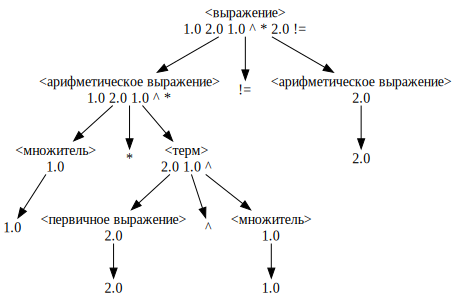

In [6]:
code = "1 * 2 ^ 1 != 2"
print(tokenize(code))
tree = parse_expr(tokenize(code), 0)
tree.print()

### ЛР 4

In [7]:
report = test(
    lambda x: parse_expr(tokenize(x), 0).attrs,
    [
        (
            "1 > 2",
            [1., 2., ">"],
        ),
        (
            "1 + 1 != 2",
            [1., 1., "+", 2., "!="],
        ),
        (
            "1 * 2 ^ 1 != 2",
            [1., 2., 1., "^", "*", 2., "!="],
        ),
        (
            "x ^ 2 - x + 1 > e^(x ^ 2)",
            ["x", 2.0, "^", "x", 1.0, "+", "-", "e", "x", 2.0, "^", "^", ">"],
        )
    ],
    True,
)

IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:200px'>Вход</div></td><td><div style='width:200px'>Ожидаемый результат</div></td><td><div style='width:200px'>Действительный результат</div></td><td>Комментарий</td></tr></thead><tbody><tr><td>

'1 > 2'
</td><td>

[1.0, 2.0, '>']
</td><td>

[1.0, 2.0, '>']</td><td>

OK
</td></tr>
<tr><td>

'1 + 1 != 2'
</td><td>

[1.0, 1.0, '+', 2.0, '!=']
</td><td>

[1.0, 1.0, '+', 2.0, '!=']</td><td>

OK
</td></tr>
<tr><td>

'1 * 2 ^ 1 != 2'
</td><td>

[1.0, 2.0, 1.0, '^', '*', 2.0, '!=']
</td><td>

[1.0, 2.0, 1.0, '^', '*', 2.0, '!=']</td><td>

OK
</td></tr>
<tr><td>

'x ^ 2 - x + 1 > e^(x ^ 2)'
</td><td>

['x', 2.0, '^', 'x', 1.0, '+', '-', 'e', 'x', 2.0, '^', '^', '>']
</td><td>

['x', 2.0, '^', 'x', 1.0, '+', '-', 'e', 'x', 2.0, '^', '^', '>']</td><td>

OK
</td></tr>
</tbody></table>